# Data Collection - Cleansing & Feature Scaling

## Data Analysis

In [50]:
# Import relavent libaries
import csv
import os
import joblib

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import math
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, kstest, skew, kurtosis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

### Initial Training dataset
Initially the training dataset used below was recorded. However as the write speed of the esp32 to InfluxDB was significantly slower (at 1Hz compared to the designed 10Hz) due to wifi speed, this dataset is no-longer used.

In [25]:
# Define the new column names
variables = ['accelX', 'accelY', 'accelZ', 'gyroX', 'gyroY', 'gyroZ', 'roll', 'pitch']

# Read and process men cycles data
men1_df = pd.read_csv('men_cycles.csv')
men2_df = pd.read_csv('men_cycles2.csv')
men_df = pd.concat([men1_df, men2_df], axis=0, ignore_index=True).drop(['Timestamp'], axis=1)
men_df.columns = variables

# Read and process kote cycles data
kote_df = pd.read_csv('kote_cycles.csv').drop(['Timestamp'], axis=1)
kote_df.columns = variables

# Read and process do cycles data
do_df = pd.read_csv('do_cycles.csv').drop(['Timestamp'], axis=1)
do_df.columns = variables

# Read and process kamae data
kamae_df = pd.read_csv('kamae.csv').drop(['Timestamp'], axis=1)
kamae_df.columns = variables

### Updated Dataset
To overcome this, a new training dataset is made where the moves are done at a slower speed, allowing the model to better understand the characteristics of each movements.

In [26]:
# Read and process cycles data
men_df = pd.read_csv('men_long.csv').drop(['timestamp'], axis=1)
kote_df = pd.read_csv('kote_long.csv').drop(['timestamp'], axis=1)
do_df = pd.read_csv('do_long.csv').drop(['timestamp'], axis=1)
kamae_df = pd.read_csv('kamae_long.csv').drop(['timestamp'], axis=1)

men_df.columns = variables
kote_df.columns = variables
do_df.columns = variables
kamae_df.columns = variables

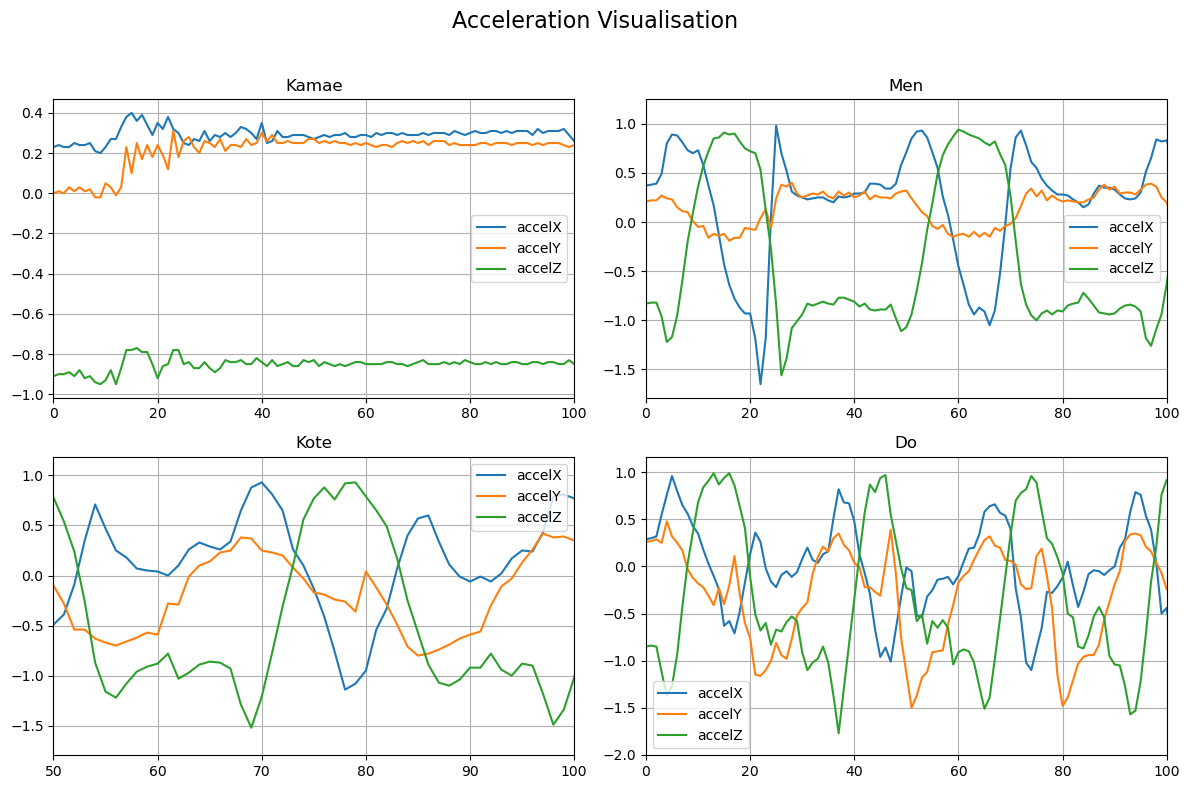

In [27]:
# Create a 2x2 plot table
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Acceleration Visualisation", fontsize=16)

# Plot for Kamae
axes[0, 0].plot(kamae_df.index, kamae_df['accelX'], label='accelX')
axes[0, 0].plot(kamae_df.index, kamae_df['accelY'], label='accelY')
axes[0, 0].plot(kamae_df.index, kamae_df['accelZ'], label='accelZ')
axes[0, 0].set_title('Kamae')
axes[0, 0].set_xlim(0, 100)
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot for Men
axes[0, 1].plot(men_df.index, men_df['accelX'], label='accelX')
axes[0, 1].plot(men_df.index, men_df['accelY'], label='accelY')
axes[0, 1].plot(men_df.index, men_df['accelZ'], label='accelZ')
axes[0, 1].set_title('Men')
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 100)
axes[0, 1].grid(True)

# Plot for Kote
axes[1, 0].plot(kote_df.index, kote_df['accelX'], label='accelX')
axes[1, 0].plot(kote_df.index, kote_df['accelY'], label='accelY')
axes[1, 0].plot(kote_df.index, kote_df['accelZ'], label='accelZ')
axes[1, 0].set_title('Kote')
axes[1, 0].legend()
axes[1, 0].set_xlim(50, 100)
axes[1, 0].grid(True)

# Plot for Do
axes[1, 1].plot(do_df.index, do_df['accelX'], label='accelX')
axes[1, 1].plot(do_df.index, do_df['accelY'], label='accelY')
axes[1, 1].plot(do_df.index, do_df['accelZ'], label='accelZ')
axes[1, 1].set_title('Do')
axes[1, 1].set_xlim(0, 100)
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

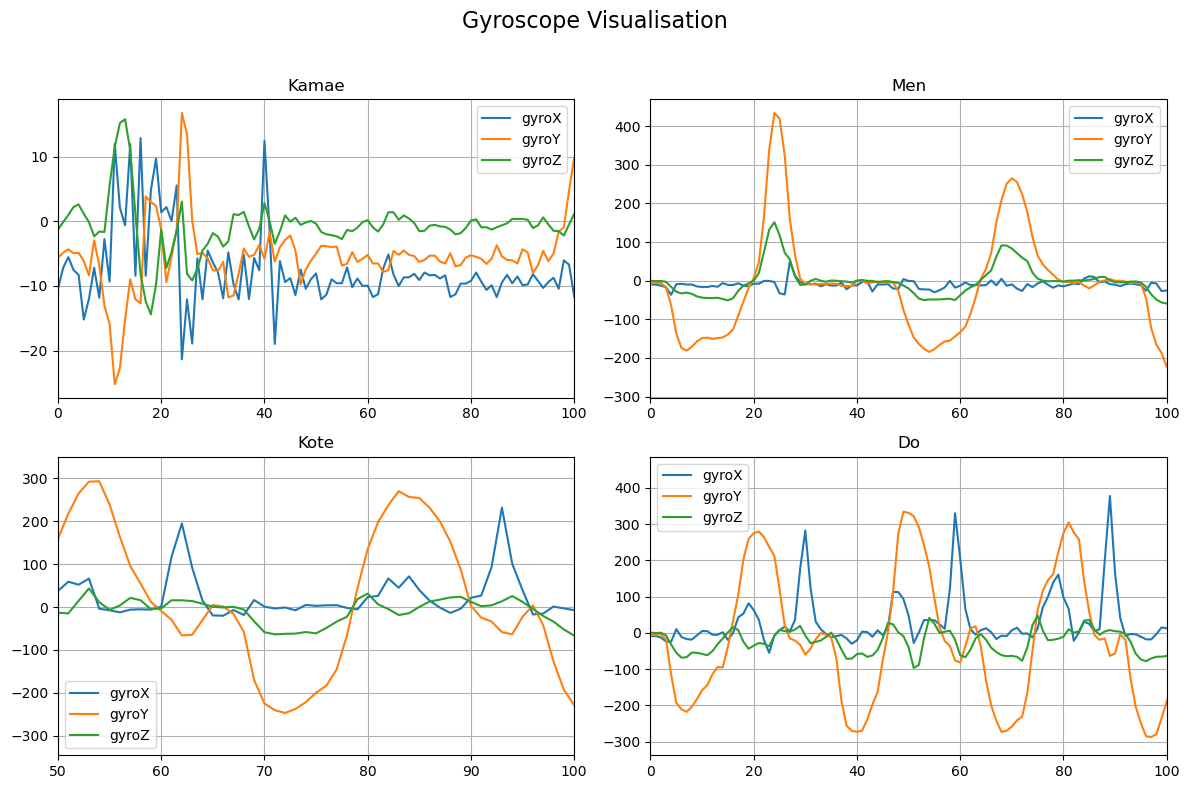

In [28]:
# Create a 2x2 plot table
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Gyroscope Visualisation", fontsize=16)

# Plot for Kamae
axes[0, 0].plot(kamae_df.index, kamae_df['gyroX'], label='gyroX')
axes[0, 0].plot(kamae_df.index, kamae_df['gyroY'], label='gyroY')
axes[0, 0].plot(kamae_df.index, kamae_df['gyroZ'], label='gyroZ')
axes[0, 0].set_title('Kamae')
axes[0, 0].set_xlim(0, 100)
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot for Men
axes[0, 1].plot(men_df.index, men_df['gyroX'], label='gyroX')
axes[0, 1].plot(men_df.index, men_df['gyroY'], label='gyroY')
axes[0, 1].plot(men_df.index, men_df['gyroZ'], label='gyroZ')
axes[0, 1].set_title('Men')
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 100)
axes[0, 1].grid(True)

# Plot for Kote
axes[1, 0].plot(kote_df.index, kote_df['gyroX'], label='gyroX')
axes[1, 0].plot(kote_df.index, kote_df['gyroY'], label='gyroY')
axes[1, 0].plot(kote_df.index, kote_df['gyroZ'], label='gyroZ')
axes[1, 0].set_title('Kote')
axes[1, 0].legend()
axes[1, 0].set_xlim(50, 100)
axes[1, 0].grid(True)

# Plot for Do
axes[1, 1].plot(do_df.index, do_df['gyroX'], label='gyroX')
axes[1, 1].plot(do_df.index, do_df['gyroY'], label='gyroY')
axes[1, 1].plot(do_df.index, do_df['gyroZ'], label='gyroZ')
axes[1, 1].set_title('Do')
axes[1, 1].set_xlim(0, 100)
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

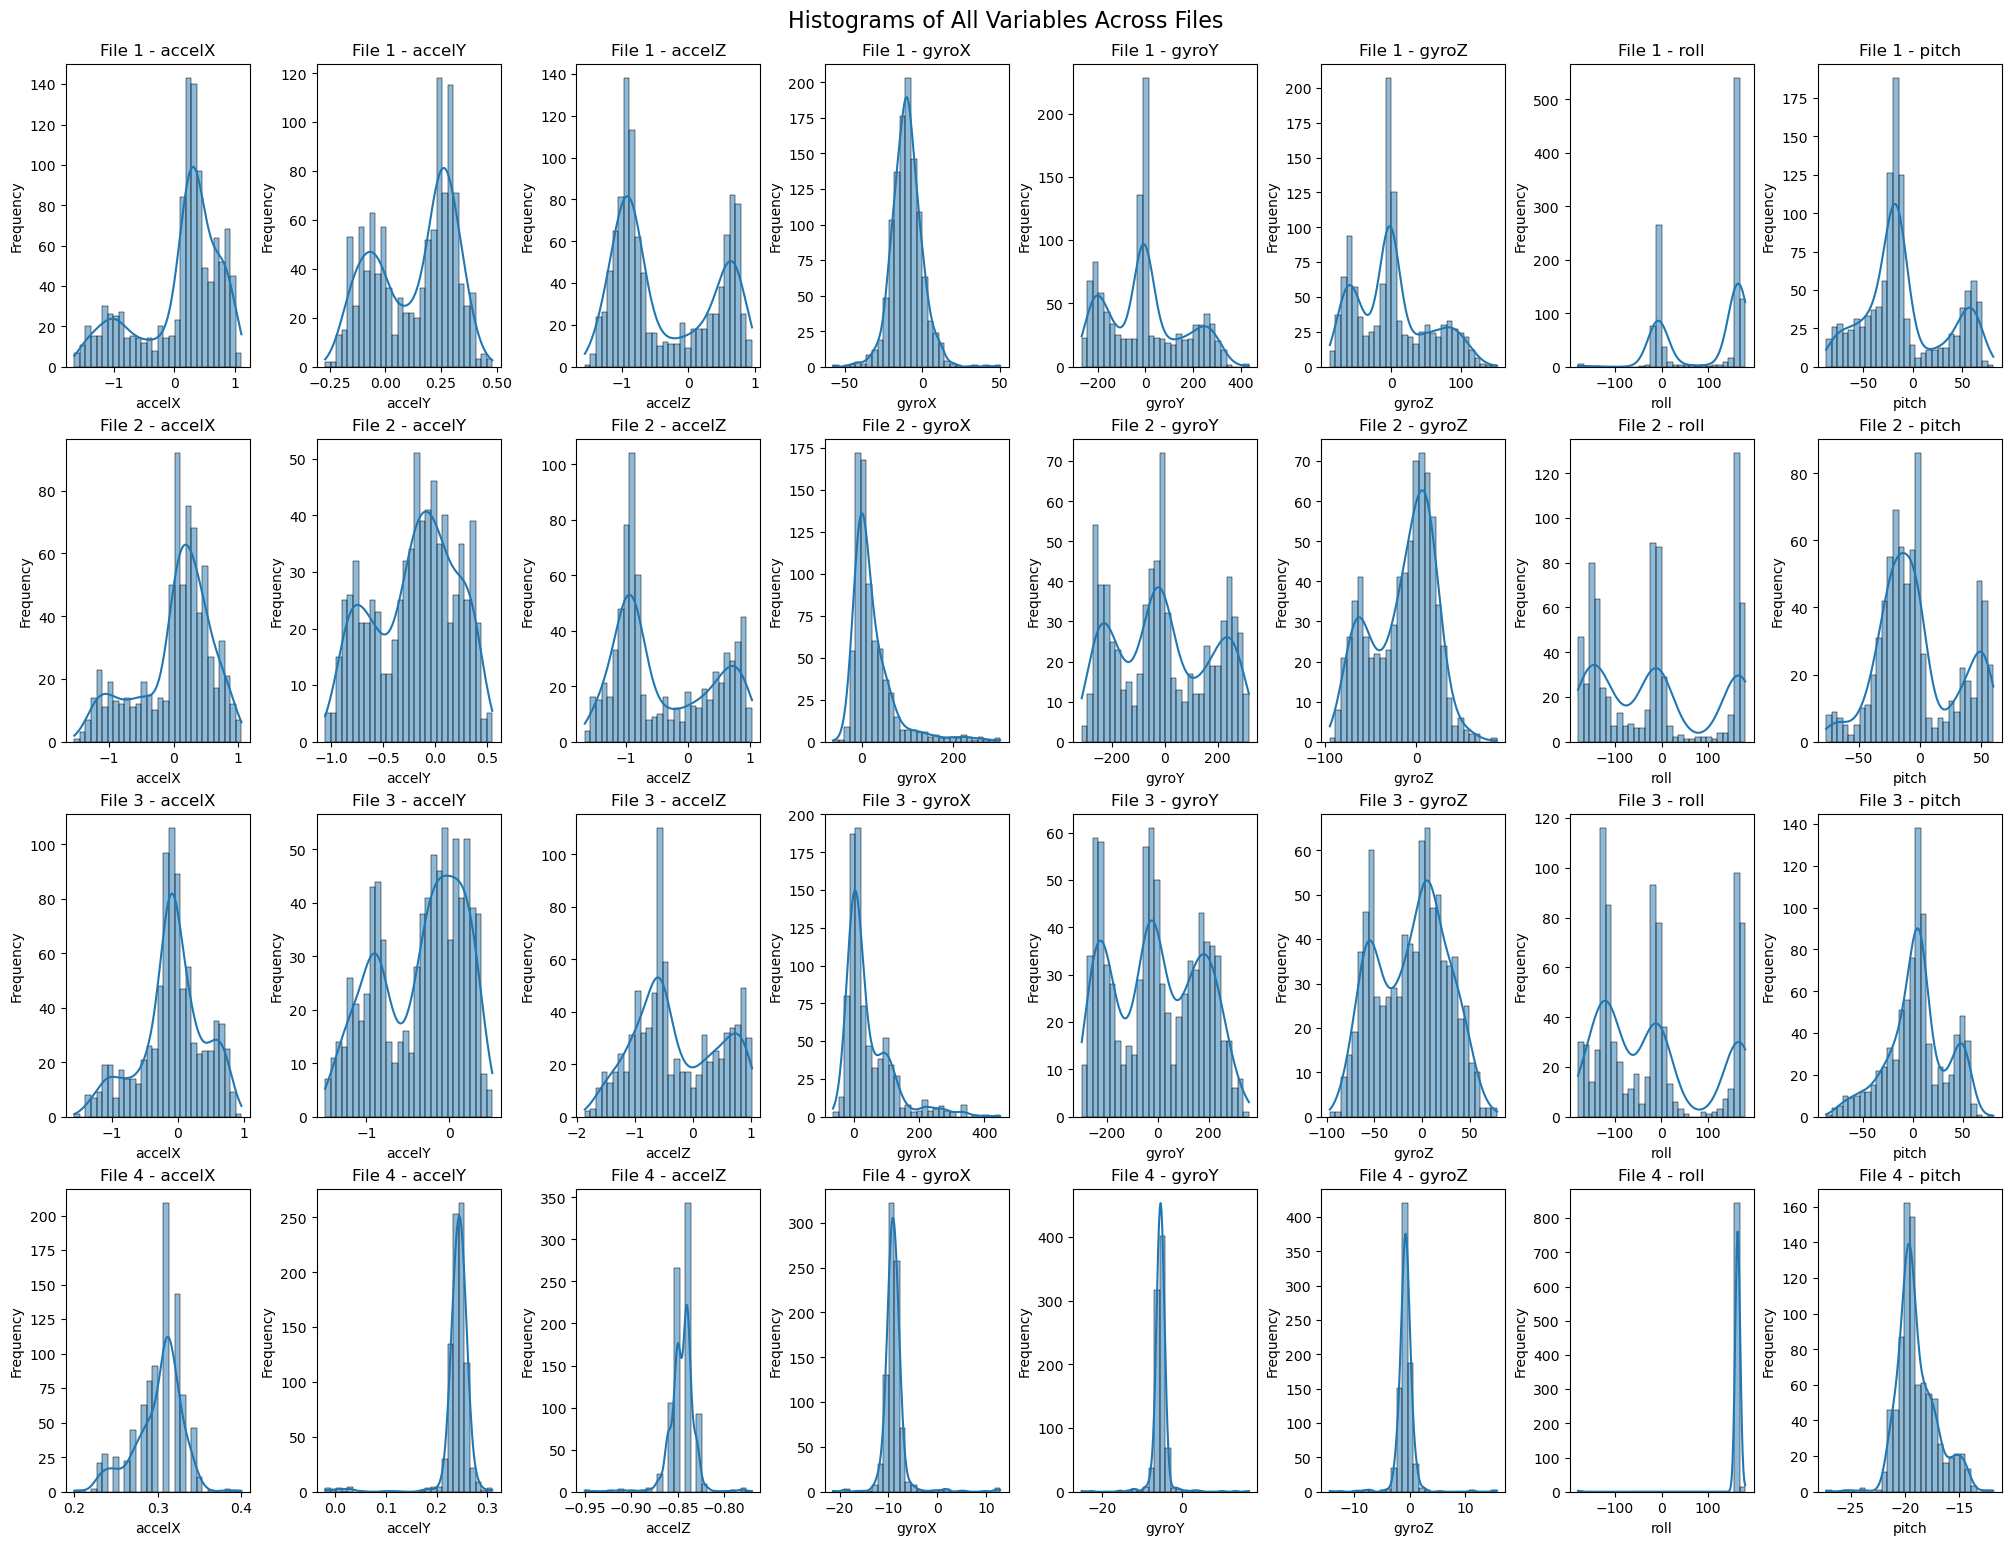

In [29]:
#Plot histograms of all data points
dataframes = [men_df, kote_df, do_df, kamae_df]

#Setup grid for subplots
fig, axes = plt.subplots(4, len(variables), figsize=(20,15), constrained_layout=True)

#Iteratively plot histograms for each variables in each dataframe
# Plot histograms for each variable in each CSV file
for i, df in enumerate(dataframes):
    for j, variable in enumerate(variables):
        ax = axes[i, j]
        sns.histplot(df[variable], kde=True, bins=30, ax=ax)
        ax.set_title(f'File {i+1} - {variable}')
        ax.set_xlabel(variable)
        ax.set_ylabel('Frequency')
        
# Adjust layout and display the plots
plt.suptitle('Histograms of All Variables Across Files', y=1.02, fontsize=16)
plt.show()

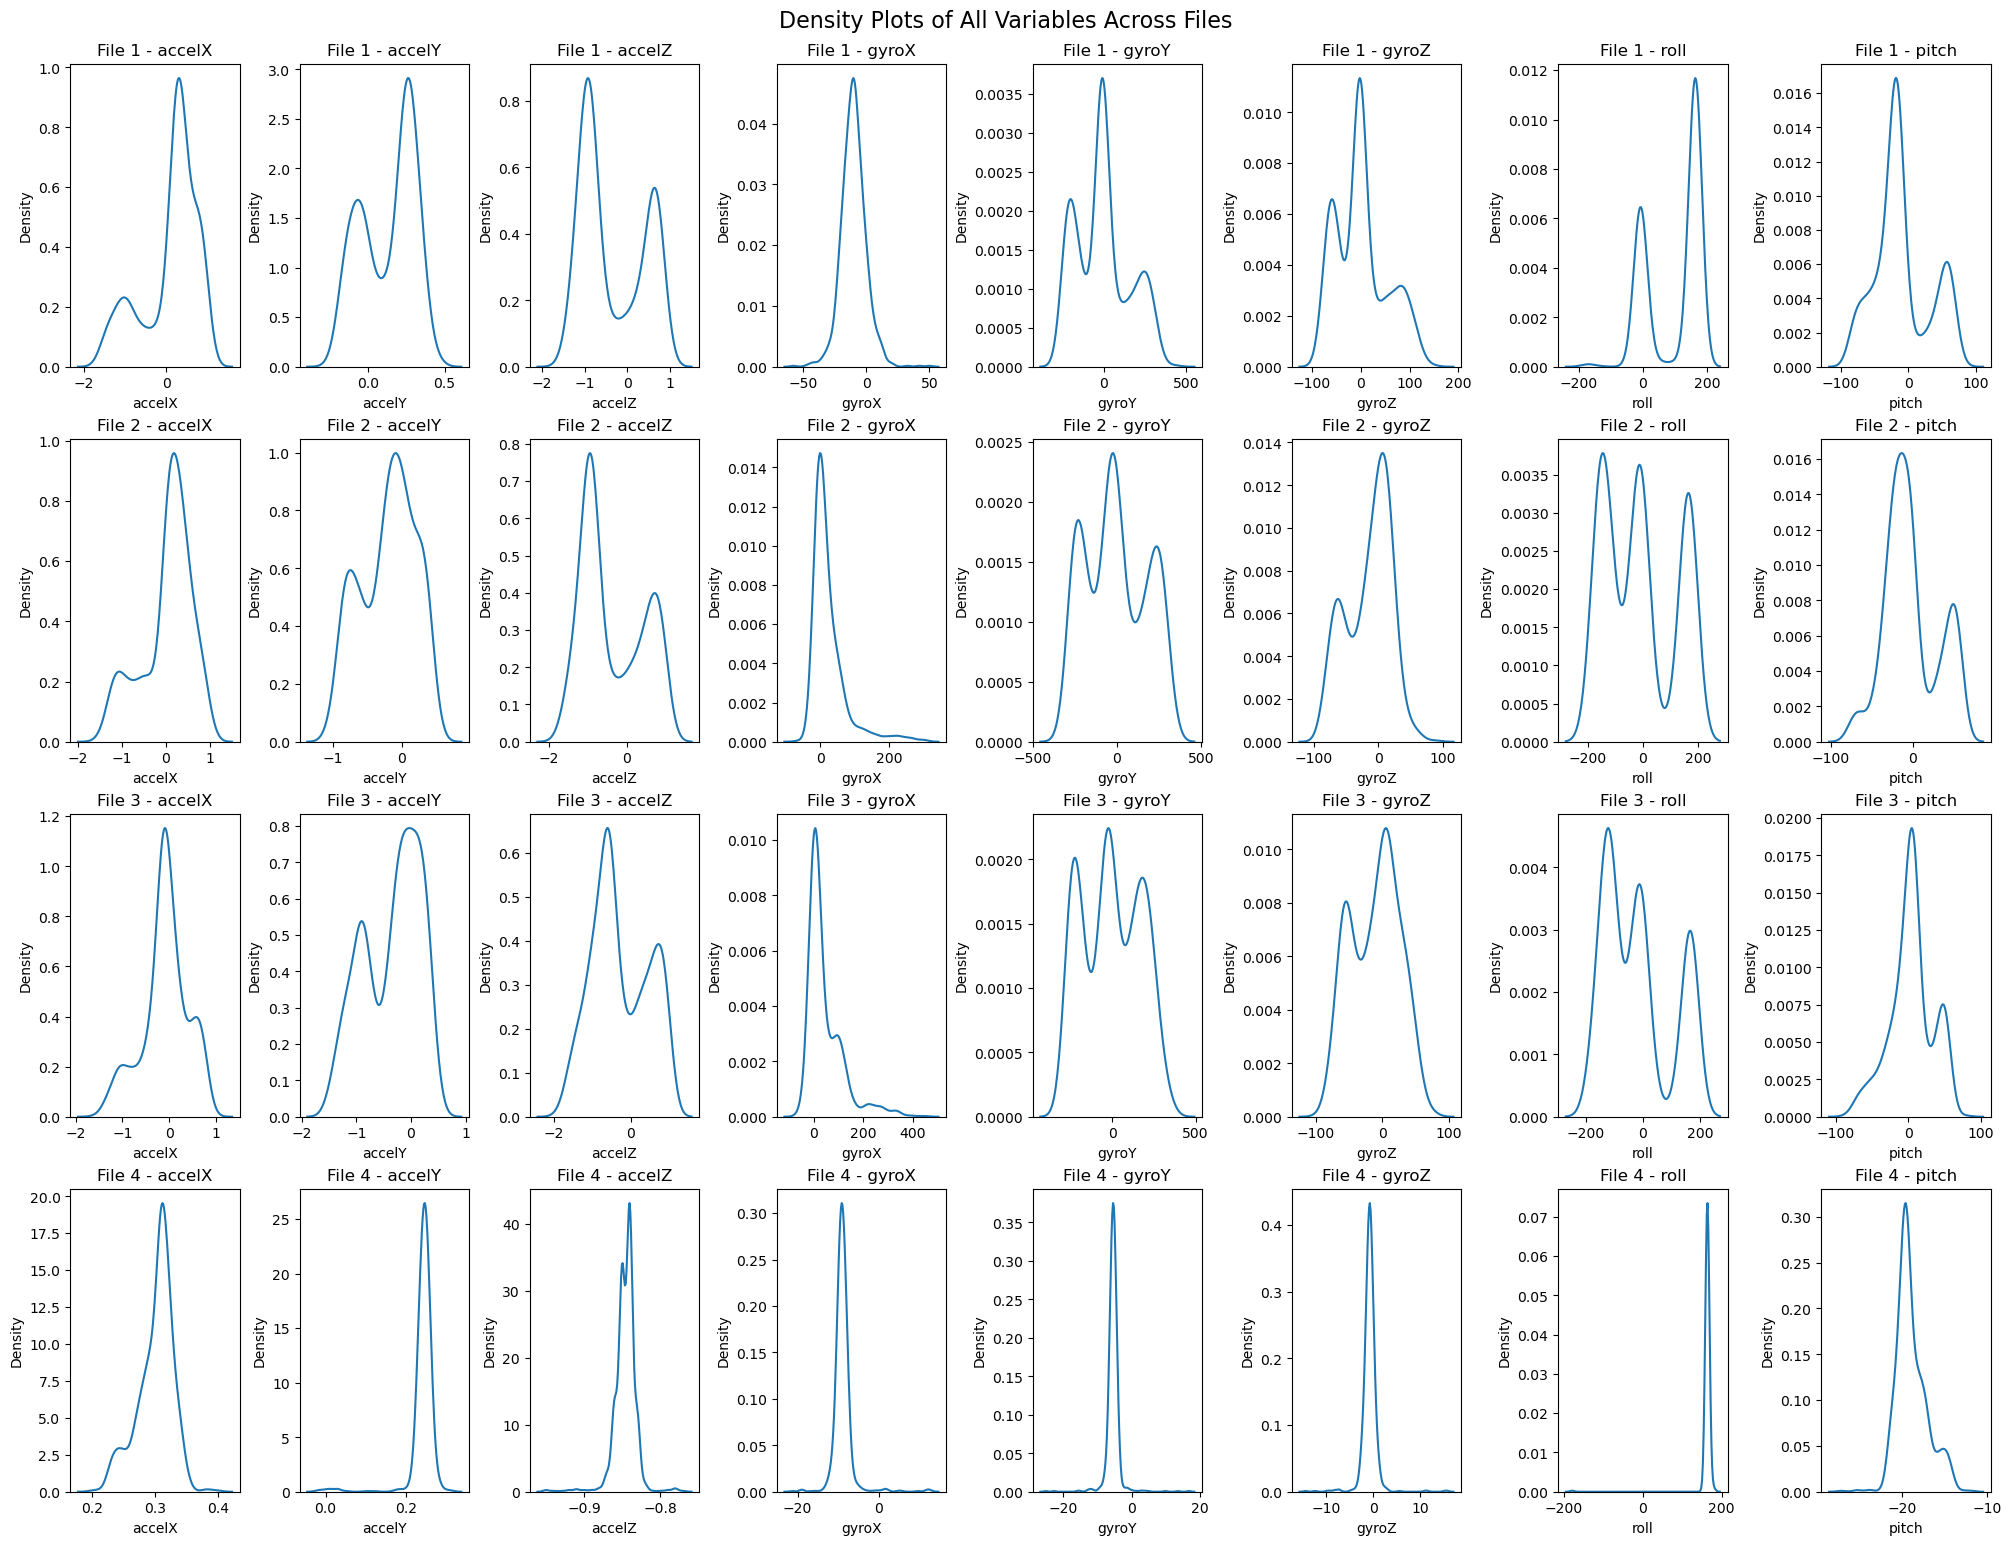

In [30]:
# Density Plots
fig, axes = plt.subplots(len(dataframes), len(variables), figsize=(20, 15), constrained_layout=True)

for i, df in enumerate(dataframes):
    for j, variable in enumerate(variables):
        ax = axes[i, j]
        sns.kdeplot(df[variable], ax=ax)
        ax.set_title(f'File {i+1} - {variable}')
        ax.set_xlabel(variable)
        ax.set_ylabel('Density')

plt.suptitle('Density Plots of All Variables Across Files', y=1.02, fontsize=16)
plt.show()


From the histogram and density plot, we observe that most of the data does not follow a normal distribution but instead exhibits a multimodal pattern. This is expected, as each variable captures different types of kendo moves, each with distinct characteristics.

Furthermore, each swing typically features a prominent peak corresponding to low-intensity movements, such as returning the sword to its resting position after a strike, and another peak associated with the strike itself.

*We can also see that the range of kamae dataframe is smaller. This is because kamae is the 'guard' stance in Kendo, meaning there is little to no movements.*

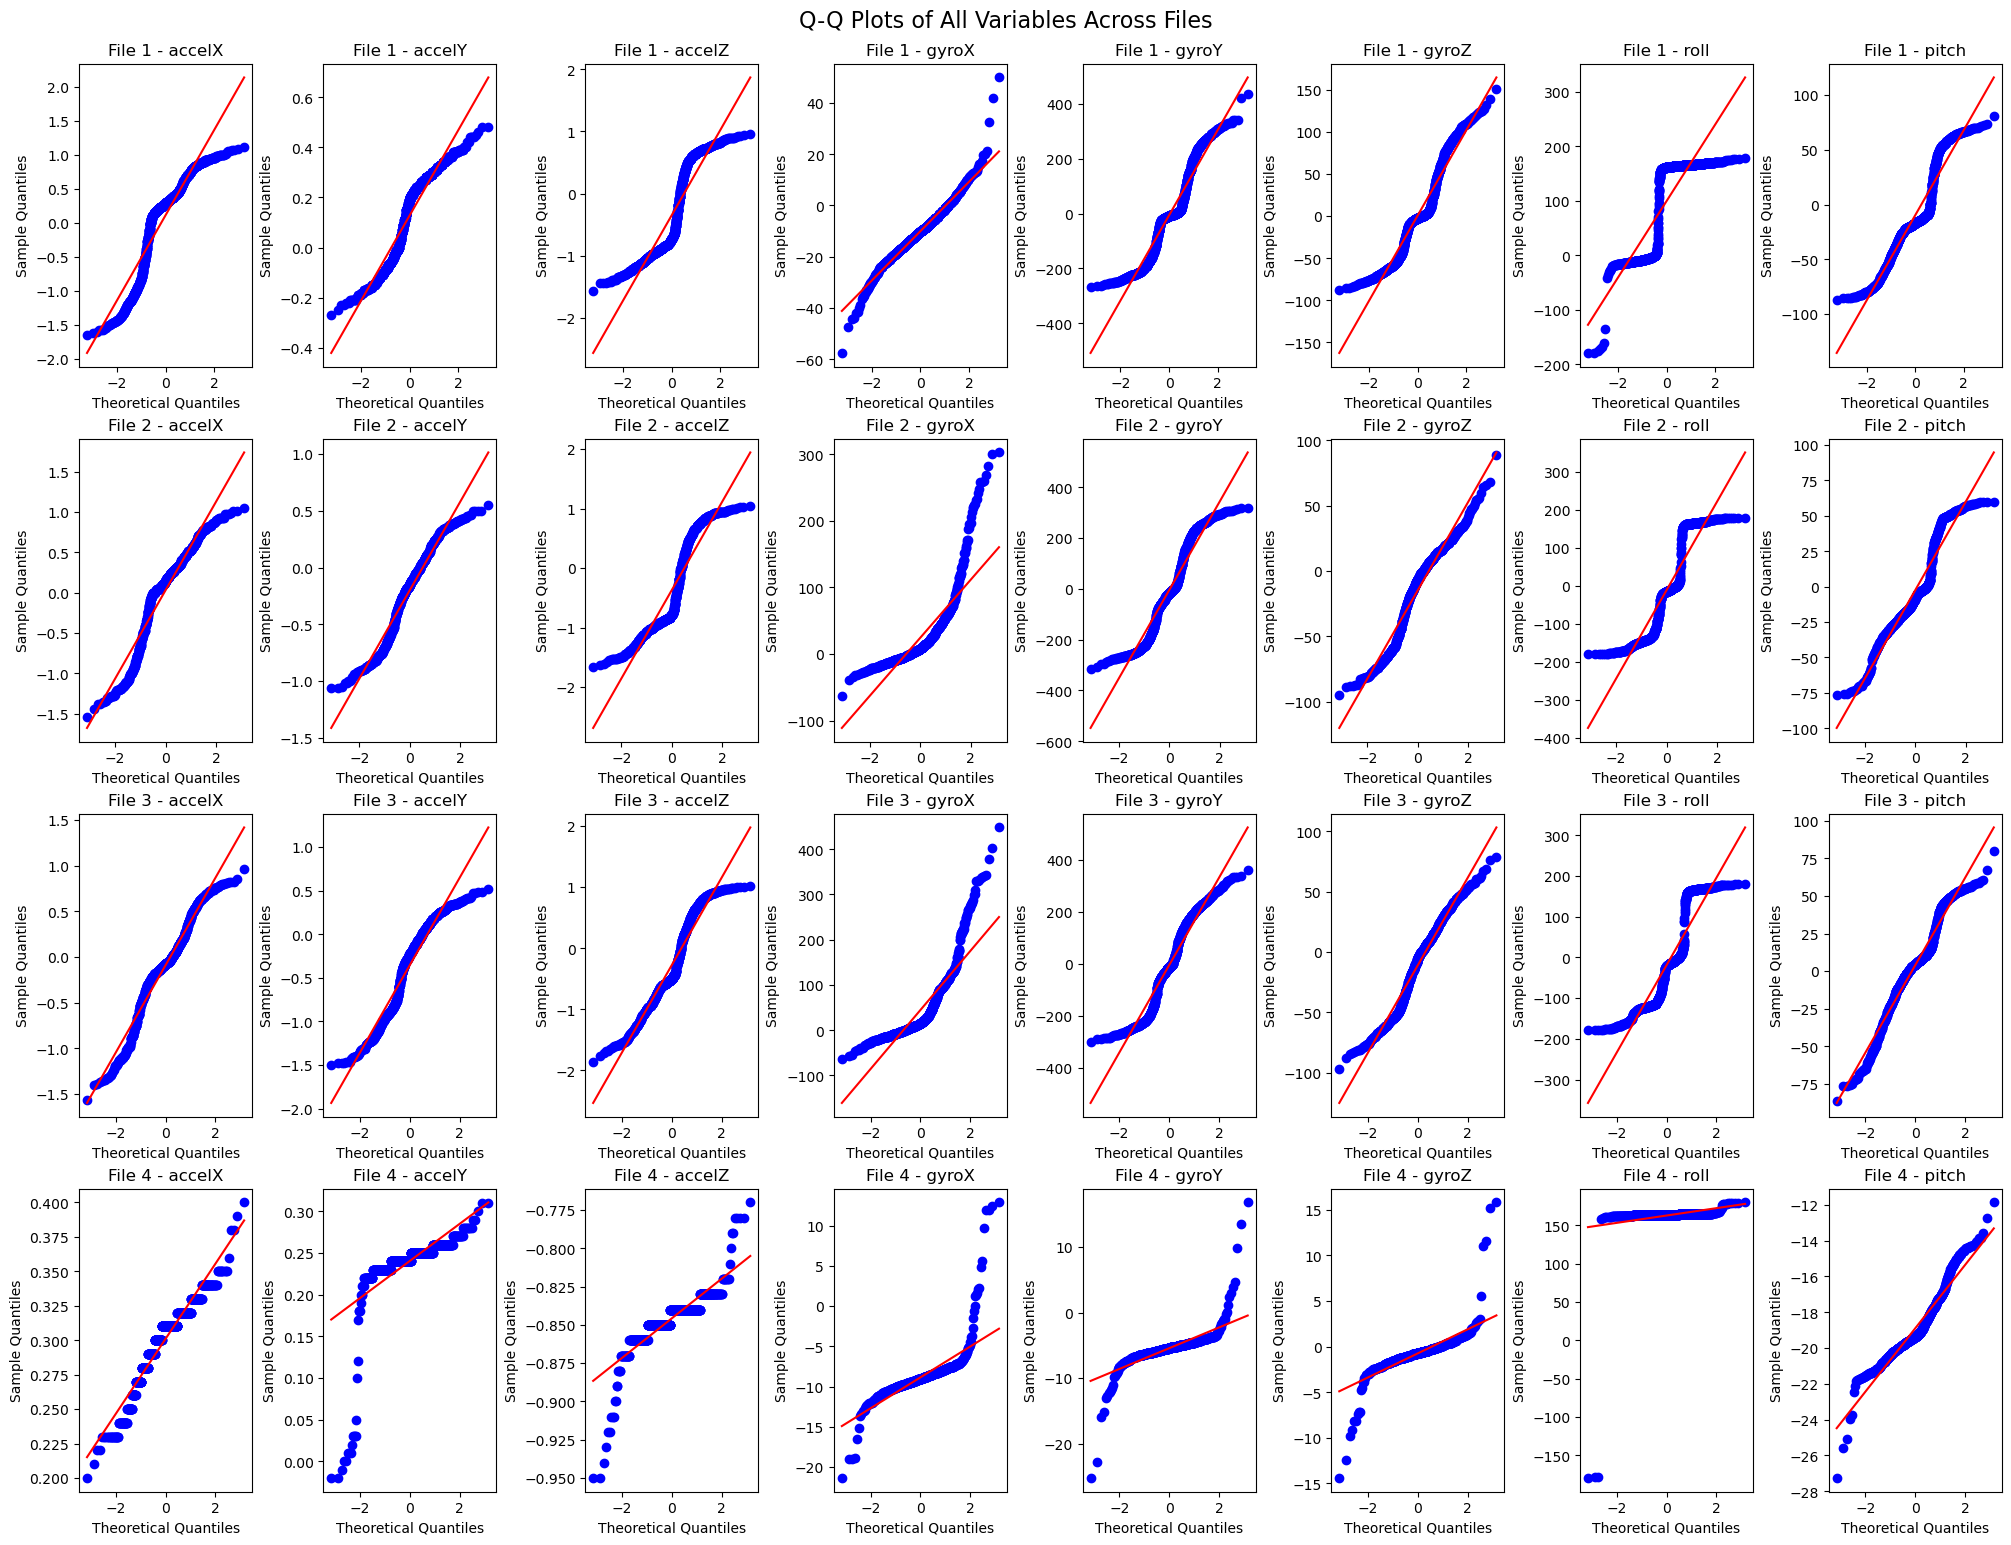

In [31]:
# Q-Q Plots
fig, axes = plt.subplots(len(dataframes), len(variables), figsize=(20, 15), constrained_layout=True)

for i, df in enumerate(dataframes):
    for j, variable in enumerate(variables):
        ax = axes[i, j]
        stats.probplot(df[variable].dropna(), dist="norm", plot=ax)
        ax.set_title(f'File {i+1} - {variable}')
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Sample Quantiles')

plt.suptitle('Q-Q Plots of All Variables Across Files', y=1.02, fontsize=16)
plt.show()


From the QQ plots, we observe that many of the variables correlating with the movements of the shinai (sword) generally follow a normal distribution. This aligns with the training dataset, which primarily consists of basic swing drills emphasising consistency and smooth, controlled motion. However, at the upper end of the plots, deviations appear in the tails, reflecting the biomechanics of reduced control during more forceful swings. 

The heavy tail and the histogram plot suggests that the dataset may not be normally distributed. To better identify if the dataset is normally distributed, the next step is to do Kolmogorov Smirnov test.

In [32]:
# Kolmogorov-Smirnov Test (with classification)

ks_results = []

for i, df in enumerate(dataframes):
    for var in variables:
        if var in df.columns:
            ks_stat, ks_p = kstest(df[var].dropna(), 'norm', args=(df[var].mean(), df[var].std()))
            classification = "Normally Distributed" if ks_p > 0.05 else "Not Normally Distributed"
            ks_results.append({
                'File': f'File {i+1}', 
                'Variable': var, 
                'KS_Stat': ks_stat, 
                'KS_p': ks_p, 
                'Classification': classification
            })

# Convert results to DataFrame
ks_df = pd.DataFrame(ks_results)
ks_df

File Variable   KS_Stat           KS_p            Classification
0   File 1   accelX  0.204792   1.612978e-41  Not Normally Distributed
1   File 1   accelY  0.152005   5.592181e-23  Not Normally Distributed
2   File 1   accelZ  0.202759   1.063089e-40  Not Normally Distributed
3   File 1    gyroX  0.042705   3.315089e-02  Not Normally Distributed
4   File 1    gyroY  0.138753   3.323342e-19  Not Normally Distributed
5   File 1    gyroZ  0.139311   2.342854e-19  Not Normally Distributed
6   File 1     roll  0.346658  2.540319e-120  Not Normally Distributed
7   File 1    pitch  0.192202   1.389176e-36  Not Normally Distributed
8   File 2   accelX  0.163819   2.878155e-18  Not Normally Distributed
9   File 2   accelY  0.065945   2.588330e-03  Not Normally Distributed
10  File 2   accelZ  0.210737   4.722196e-30  Not Normally Distributed
11  File 2    gyroX  0.179410   7.588056e-22  Not Normally Distributed
12  File 2    gyroY  0.079059   1.422376e-04  Not Normally Distributed
13  File 2    gyroZ  0.101391   3.024877e-07  Not Normally Distributed
14  File 2     roll  0.167126   5.342877e-19  Not Normally Distributed
15  File 2    pitch  0.150092   2.161830e-15  Not Normally Distributed
16  File 3   accelX  0.101050   6.023252e-08  Not Normally Distributed
17  File 3   accelY  0.102905   3.169532e-08  Not Normally Distributed
18  File 3   accelZ  0.136343   3.950867e-14  Not Normally Distributed
19  File 3    gyroX  0.198419   1.463315e-29  Not Normally Distributed
20  File 3    gyroY  0.093400   7.509360e-07  Not Normally Distributed
21  File 3    gyroZ  0.079607   4.288923e-05  Not Normally Distributed
22  File 3     roll  0.145257   5.496727e-16  Not Normally Distributed
23  File 3    pitch  0.091824   1.231907e-06  Not Normally Distributed
24  File 4   accelX  0.187129   6.712519e-27  Not Normally Distributed
25  File 4   accelY  0.309383   8.998079e-74  Not Normally Distributed
26  File 4   accelZ  0.220995   1.868948e-37  Not Normally Distributed
27  File 4    gyroX  0.199034   2.105347e-30  Not Normally Distributed
28  File 4    gyroY  0.187050   7.071329e-27  Not Normally Distributed
29  File 4    gyroZ  0.153551   3.264300e-18  Not Normally Distributed
30  File 4     roll  0.465657  9.103785e-172  Not Normally Distributed
31  File 4    pitch  0.128874   6.099529e-13  Not Normally Distributed

The test shows that the dataset is in-fact not normally distributed. While many machine learning methodology assumes normality, it is important in this case __not__ to standardise as the dataset tail is an important feature in kendo movements.

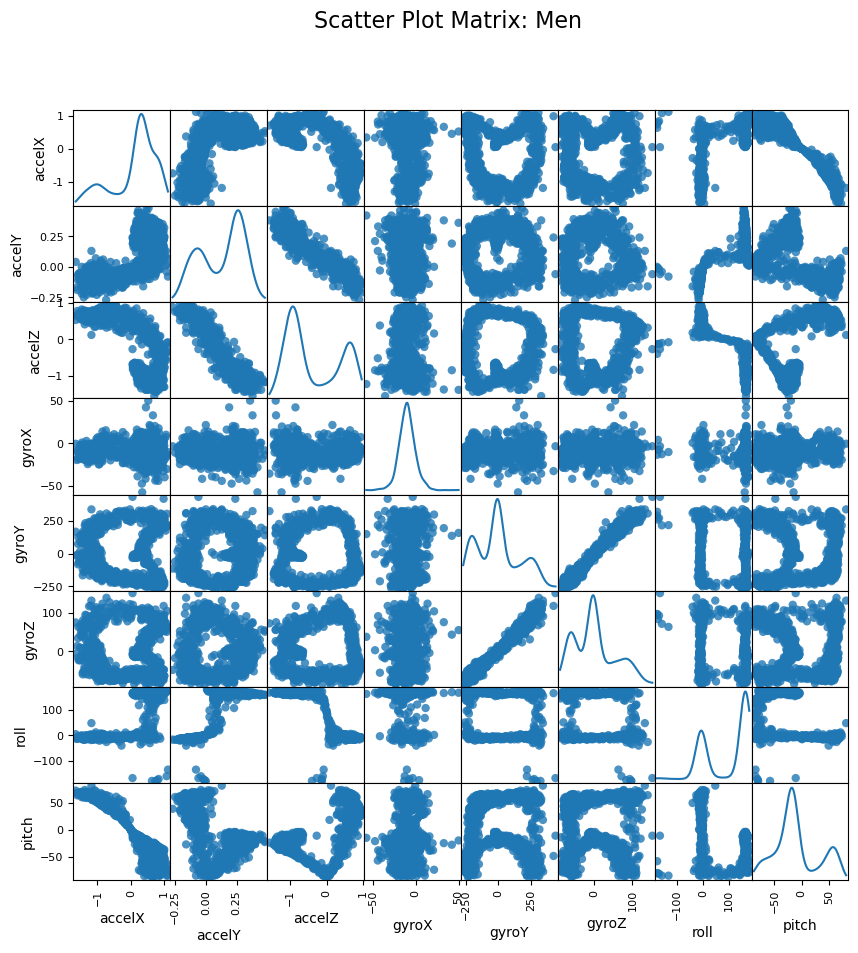

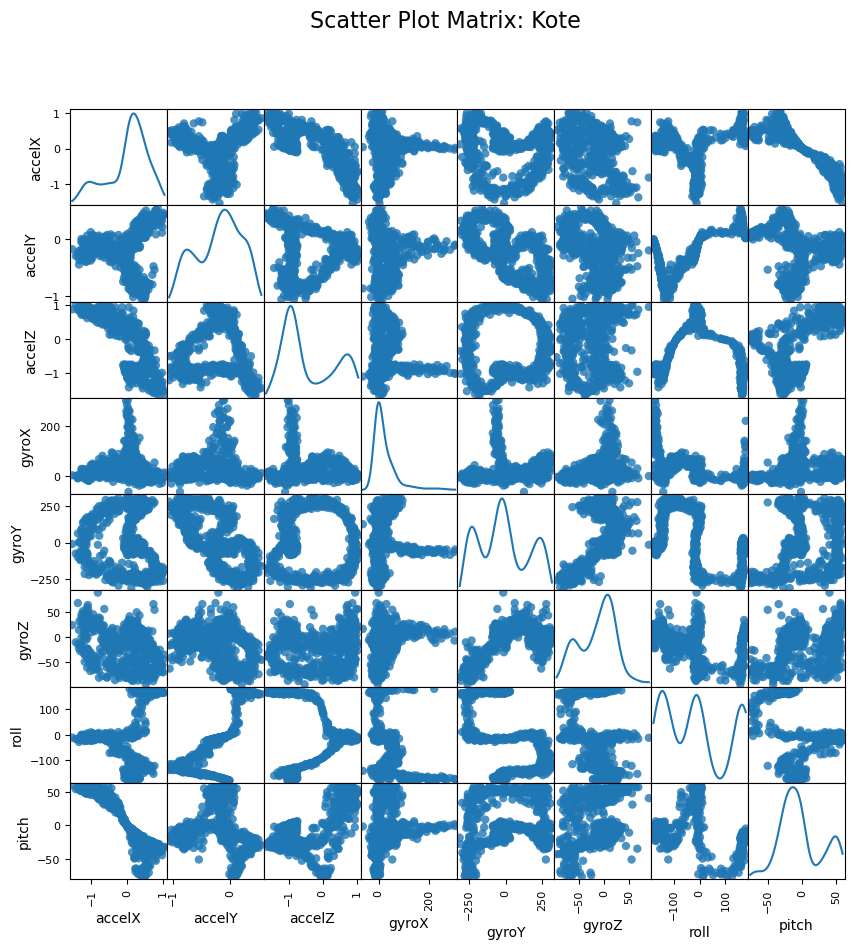

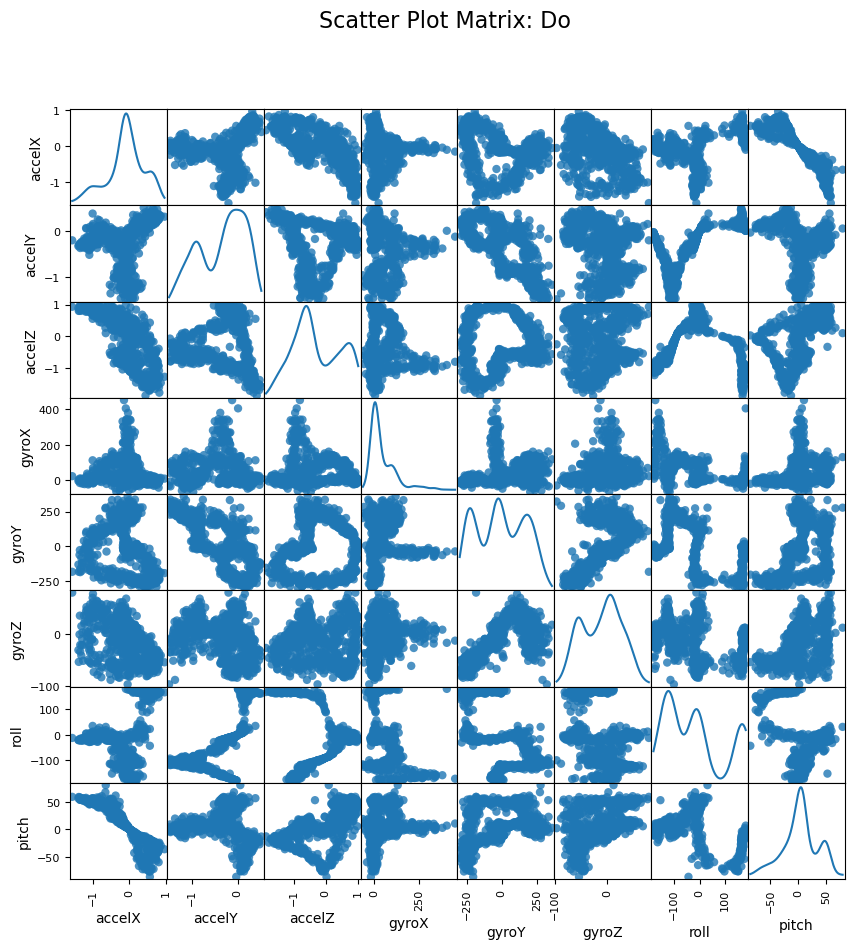

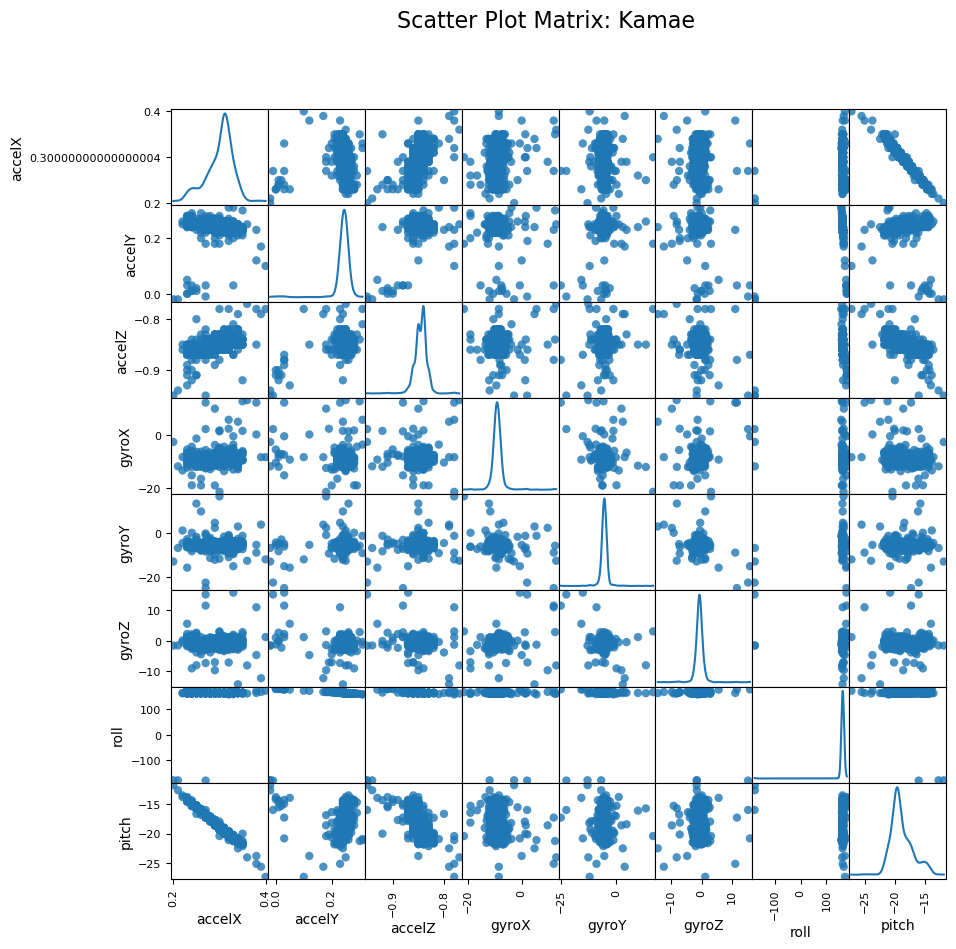

In [33]:
# Define a function to plot scatter matrix for a given dataframe
def plot_scatter_matrix(df, title):
    scatter_matrix(df, alpha=0.8, figsize=(10, 10), diagonal='kde', marker='o')
    plt.suptitle(title, fontsize=16)
    plt.show()

# Plot scatter matrices for each dataframe
plot_scatter_matrix(men_df, "Scatter Plot Matrix: Men")
plot_scatter_matrix(kote_df, "Scatter Plot Matrix: Kote")
plot_scatter_matrix(do_df, "Scatter Plot Matrix: Do")
plot_scatter_matrix(kamae_df, "Scatter Plot Matrix: Kamae")

## Feature Extraction

Since we are dealing with raw time-series data, its important to gather the key characteristics of our dataset for:
- Dimensional Reduction
- Highlight key patterns
- Improve ML performance with fixed-size feature vectors

In [34]:
def extract_features(df, move_label):
    features_list = []
    window_size = 40  # Adjust based on your data sampling rate and movement duration
    step_size = 5     # Overlapping windows; adjust as needed

    # Iterate over the data using a sliding window
    for start in range(0, df.shape[0] - window_size + 1, step_size):
        window = df.iloc[start:start+window_size]
        features = {}
        for axis in ['accelX', 'accelY', 'accelZ', 'gyroX', 'gyroY', 'gyroZ', 'roll', 'pitch']:
            axis_data = window[axis]
            features[f'{axis}_mean'] = axis_data.mean()
            features[f'{axis}_std'] = axis_data.std()
            features[f'{axis}_max'] = axis_data.max()
            features[f'{axis}_min'] = axis_data.min()
            features[f'{axis}_skew'] = skew(axis_data)
            features[f'{axis}_kurtosis'] = kurtosis(axis_data, fisher=False)  # Pearson definition
            # Add more features if needed
        features['move'] = move_label
        features_list.append(features)
    return pd.DataFrame(features_list)

In [35]:
# Extract features for each move
features_men = extract_features(men_df, 'men')
features_do = extract_features(do_df, 'do')
features_kote = extract_features(kote_df, 'kote')
features_kamae = extract_features(kamae_df, 'kamae')

# Combine all features into a single DataFrame
features_all = pd.concat([features_men, features_do, features_kote, features_kamae], ignore_index=True)

In [36]:
# Encode the moveLabelEncoder labels into numerical values
le = LabelEncoder()
features_all['move_label'] = le.fit_transform(features_all['move'])
y = features_all['move_label']

# Save the label encoder
joblib.dump(le, 'label_encoder.pkl')
print('Label encoder has been serialized to label_encoder.pkl')

# Exclude non-feature columns
X = features_all.drop(columns=['move', 'move_label'])

Label encoder has been serialized to label_encoder.pkl


In [37]:
X

accelX_mean  accelX_std  accelX_max  accelX_min  accelX_skew  \
0        0.12000    0.655000        0.98       -1.65    -1.044003   
1        0.10075    0.643525        0.98       -1.65    -1.045308   
2        0.05125    0.600650        0.98       -1.65    -1.226581   
3        0.11500    0.645934        0.98       -1.65    -1.078030   
4        0.24150    0.567381        0.98       -1.65    -1.756882   
..           ...         ...         ...         ...          ...   
681      0.27400    0.008102        0.29        0.26     0.328125   
682      0.27525    0.008469        0.29        0.26     0.305673   
683      0.27600    0.008412        0.29        0.26     0.334987   
684      0.27800    0.009392        0.30        0.26     0.218173   
685      0.28000    0.012810        0.33        0.26     1.482318   

     accelX_kurtosis  accelY_mean  accelY_std  accelY_max  accelY_min  ...  \
0           3.197581      0.12425    0.183120        0.40       -0.19  ...   
1           3.263920      0.12850    0.186101        0.40       -0.19  ...   
2           3.602021      0.14700    0.190279        0.40       -0.19  ...   
3           3.349310      0.18200    0.167197        0.40       -0.19  ...   
4           6.138170      0.18900    0.154036        0.40       -0.15  ...   
..               ...          ...         ...         ...         ...  ...   
681         2.664062      0.23775    0.008002        0.25        0.22  ...   
682         2.385889      0.23700    0.007579        0.25        0.22  ...   
683         2.245747      0.23650    0.007355        0.25        0.22  ...   
684         2.340725      0.23700    0.010427        0.28        0.22  ...   
685         6.953125      0.23900    0.018369        0.31        0.18  ...   

     roll_max  roll_min  roll_skew  roll_kurtosis  pitch_mean  pitch_std  \
0      170.95   -167.30  -0.774691       2.450141    -9.53200  38.361172   
1      170.95   -167.30  -0.777710       2.461654    -8.80150  38.074041   
2      166.23   -167.30  -0.887822       2.640920    -4.39800  33.322073   
3      167.35   -167.30  -1.619014       4.727678    -7.79050  36.283591   
4      167.35   -167.30  -1.622622       4.749536   -16.15450  33.433942   
..        ...       ...        ...            ...         ...        ...   
681    165.81    163.41   0.061176       3.152428   -17.11875   0.473726   
682    165.81    163.41   0.116708       3.380330   -17.18200   0.512501   
683    165.81    163.41   0.039658       3.465187   -17.26575   0.499440   
684    165.81    161.50  -1.826986       9.310577   -17.39725   0.534300   
685    167.99    159.22  -1.413716      10.167510   -17.52350   0.763580   

     pitch_max  pitch_min  pitch_skew  pitch_kurtosis  
0        81.22     -82.26    0.660637        2.990723  
1        81.22     -82.26    0.626346        3.025893  
2        81.22     -63.24    1.087077        3.370205  
3        81.22     -83.72    0.790669        3.334014  
4        81.22     -83.72    1.129601        5.218836  
..         ...        ...         ...             ...  
681     -16.13     -18.11   -0.312608        2.490117  
682     -16.13     -18.11   -0.147405        2.091614  
683     -16.38     -18.11   -0.070659        1.783260  
684     -16.38     -18.61    0.000609        2.301495  
685     -16.09     -20.92   -2.052559       10.992982  

[686 rows x 48 columns]

### Plot the Distribution of our New Variables

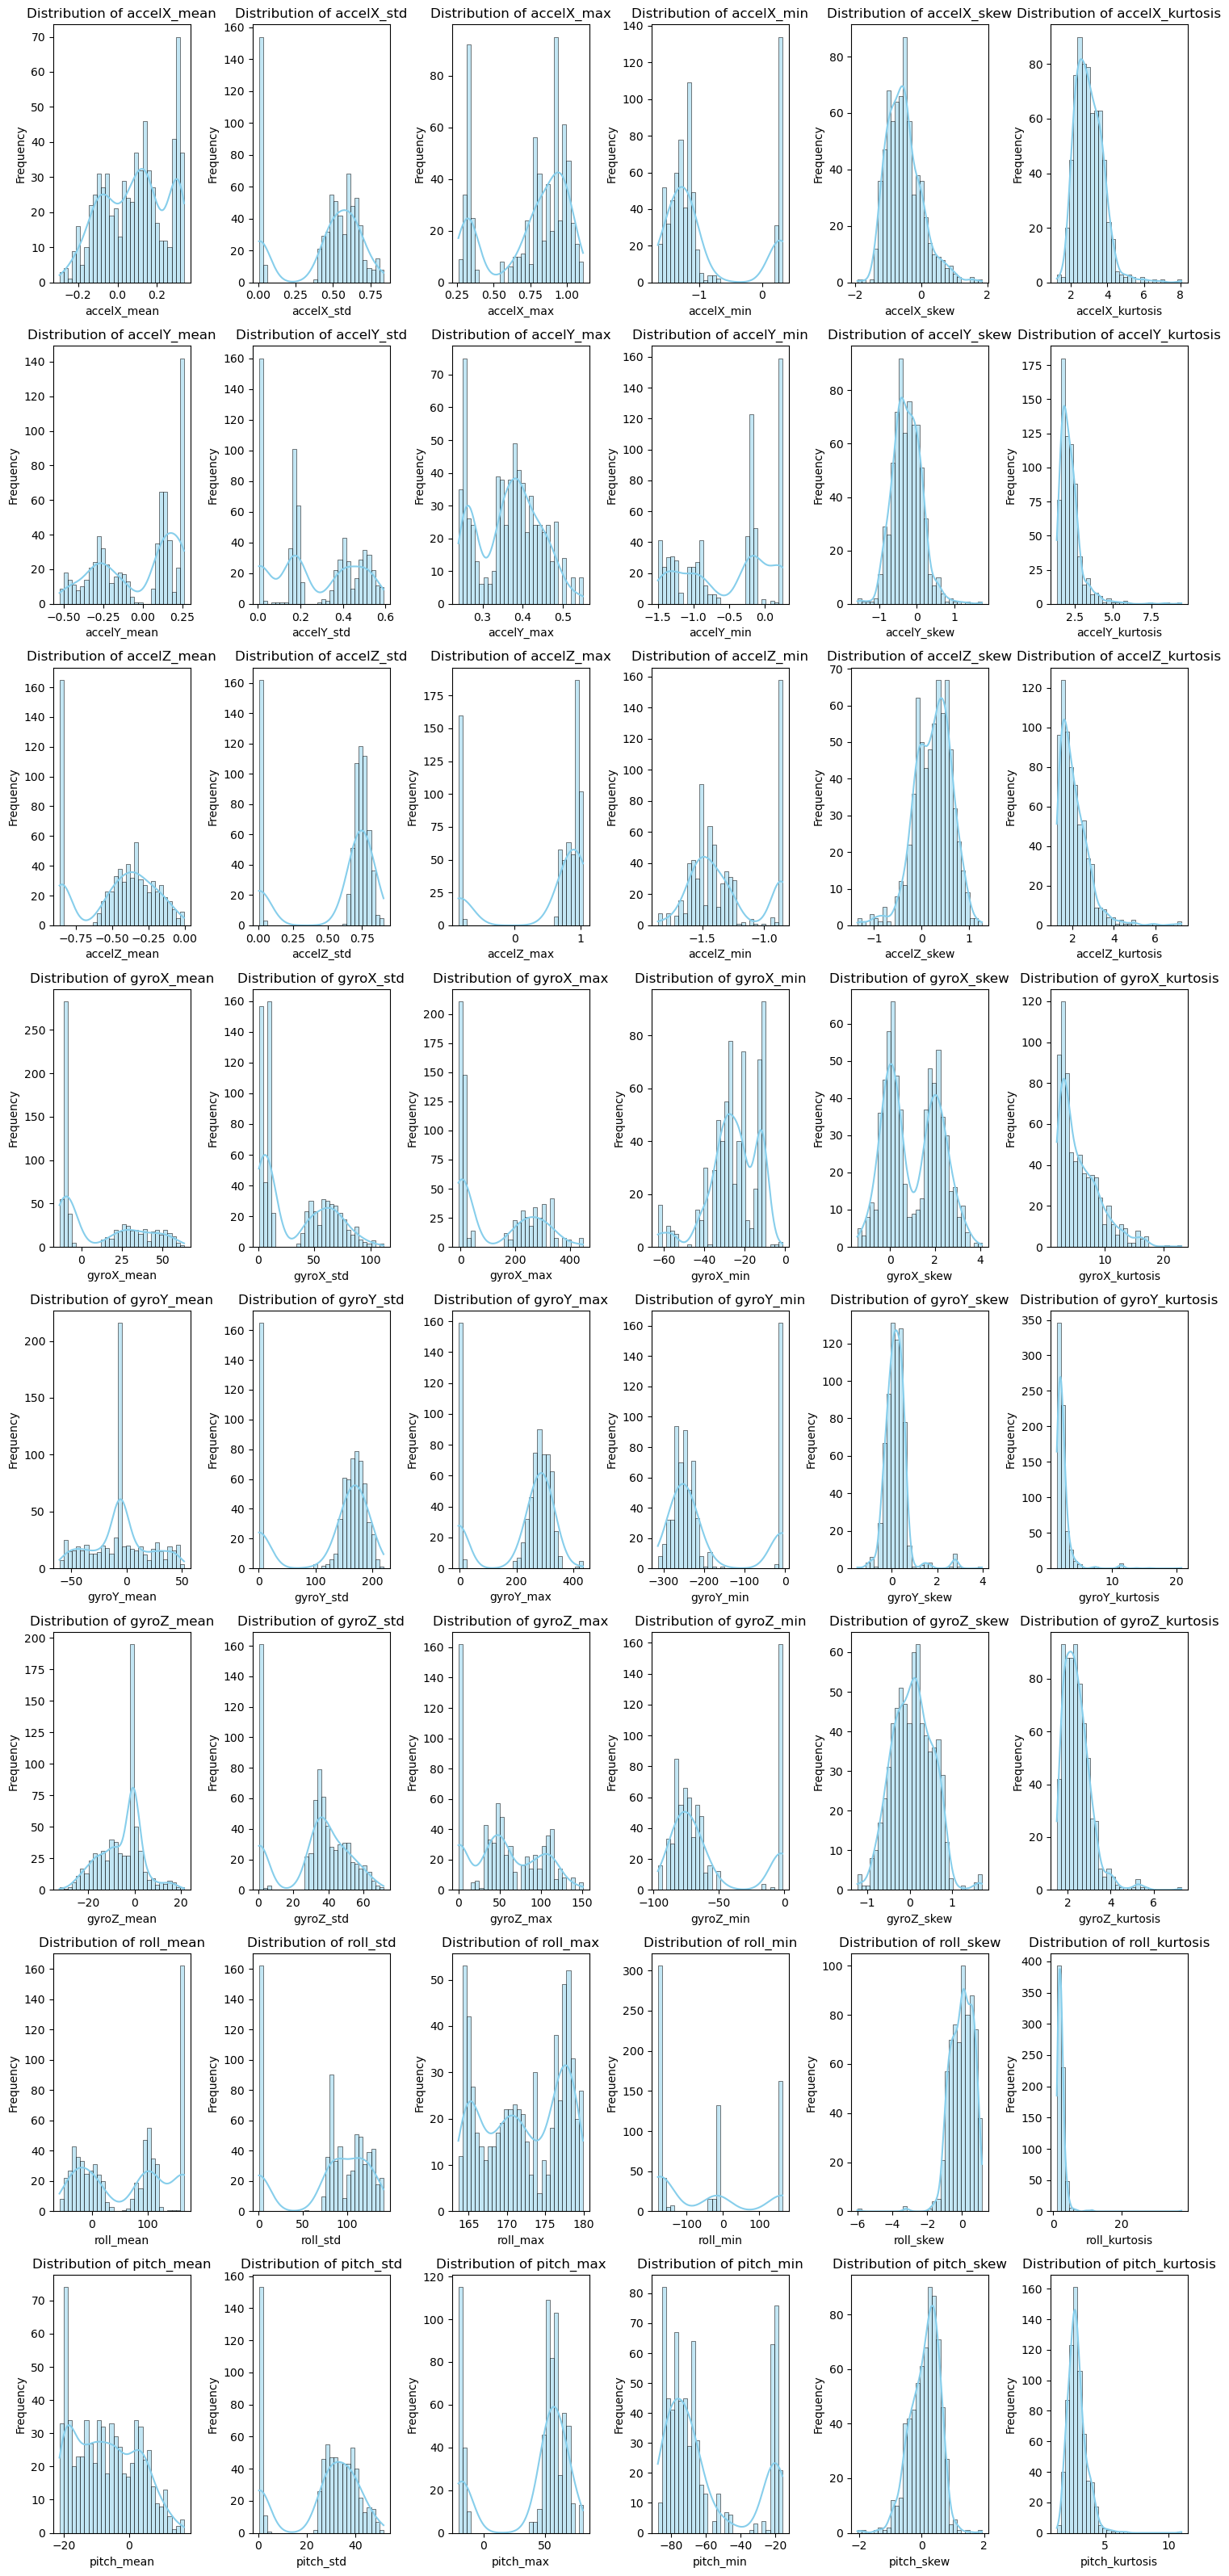

In [38]:
feature_names = X.columns.tolist()
num_features = len(feature_names)

cols = 6
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(feature_names):
    sns.histplot(X[feature], kde=True, ax=axes[idx], color='skyblue', bins=30)
    axes[idx].set_title(f'Distribution of {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

## Data Scaling

To ensure effective model training, we must scale the data to account for algorithm sensitivity to feature scale. Many machine learning models are sensitive to input feature scales; without scaling, features with larger values can disproportionately influence the model, overshadowing smaller ones. Scaling levels the playing field, enabling features to contribute equally to the model’s performance.

For this project, we experimented with 2 different scaling techniques:  __MinMaxScaler__ and __RobustScaler__. Each scaler applies a unique method to transform data and is suited for different scenarios. While standard scaler can also be used, since we have established that the data is not normally distributed, we ignored it.



In [39]:
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

scaled_features = {}

for scaler_name, scaler in scalers.items():
    # Fit the scaler on the feature matrix X
    X_scaled = scaler.fit_transform(X)
    scaled_features[scaler_name] = X_scaled
    joblib.dump(scaler, f'{scaler_name}.pkl')

## Model Training & Evaluation

In [40]:
def train_and_evaluate(X_scaled, y, scaler_name):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Define the classifier
    classifier = SVC(kernel='rbf', gamma='scale', random_state=42)
    
    # Train the classifier
    classifier.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = classifier.predict(X_test)
    
    # Evaluate the classifier
    print(f'Classification Report using {scaler_name}:')
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Cross-validation
    pipeline = Pipeline([
        ('classifier', SVC(kernel='rbf', gamma='scale', random_state=42))
    ])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_scaled, y, cv=kf, scoring='accuracy')
    print(f'Cross-Validation Accuracy using {scaler_name}: {scores.mean():.3f} ± {scores.std():.3f}')
    print('-' * 60)
    
    return classifier


In [41]:
classifier = train_and_evaluate(scaled_features['RobustScaler'], y, 'RobustScaler')

Classification Report using RobustScaler:
              precision    recall  f1-score   support

          do       1.00      1.00      1.00        38
       kamae       1.00      1.00      1.00        35
        kote       1.00      1.00      1.00        16
         men       1.00      1.00      1.00        49

    accuracy                           1.00       138
   macro avg       1.00      1.00      1.00       138
weighted avg       1.00      1.00      1.00       138

Cross-Validation Accuracy using RobustScaler: 1.000 ± 0.000
------------------------------------------------------------


This classification Report is highly suspicious of overfitting. This could be due to a various number of reasons, including the relatively small dataset. Therefore, after random forest classifier, we must test it with a new dataset that was not included in the initial one.

In [42]:
joblib.dump(classifier, 'kendo_move_classifier.pkl')

['kendo_move_classifier.pkl']

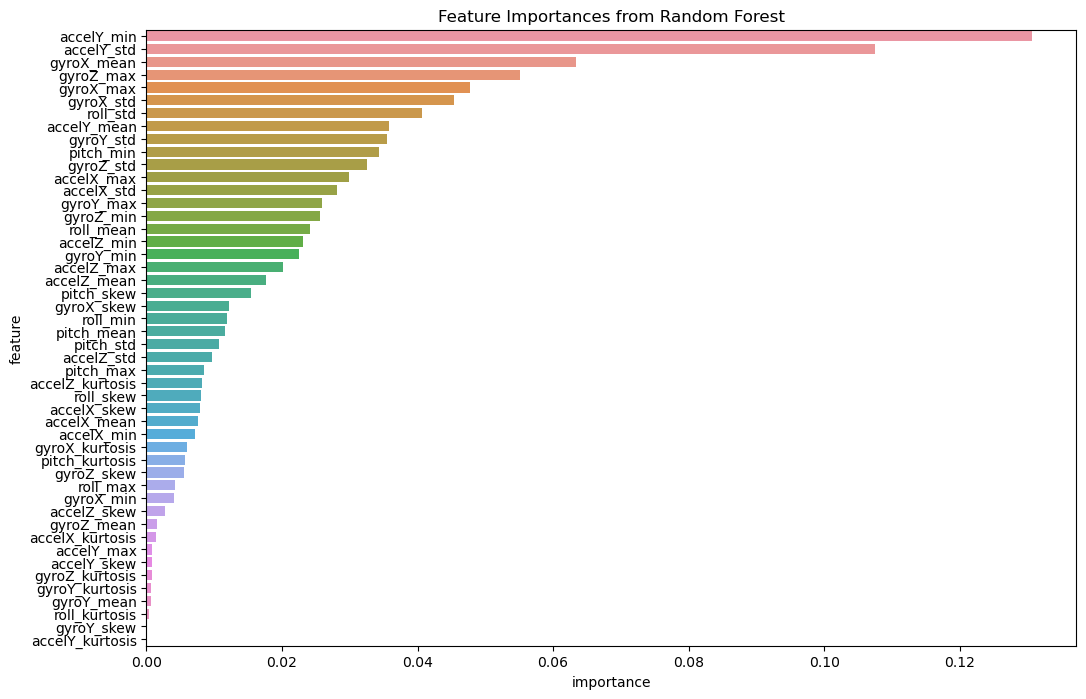

In [43]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42) #we love the ultimate answer to the universe
rf_classifier.fit(X, y)

# Get feature importances
importances = rf_classifier.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort and plot
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()


## Test with Unseen Data

In [68]:
def extract_features2(df, move_label_column=None):
    features_list = []
    window_size = 40  # Adjust based on the test dataset
    step_size = 5     # Adjust based on the test dataset

    for start in range(0, df.shape[0] - window_size + 1, step_size):
        window = df.iloc[start:start+window_size]
        features = {}
        for axis in ['accelX', 'accelY', 'accelZ', 'gyroX', 'gyroY', 'gyroZ', 'roll', 'pitch']:
            axis_data = window[axis]
            features[f'{axis}_mean'] = axis_data.mean()
            features[f'{axis}_std'] = axis_data.std()
            features[f'{axis}_max'] = axis_data.max()
            features[f'{axis}_min'] = axis_data.min()
            features[f'{axis}_skew'] = skew(axis_data)
            features[f'{axis}_kurtosis'] = kurtosis(axis_data, fisher=False)
        
        # Assign the most frequent label in the window
        if move_label_column is not None:
            features['label'] = window[move_label_column].mode()[0]
        features_list.append(features)
    
    return pd.DataFrame(features_list)


Accuracy: 0.875
Weighted F1-Score: 0.874
Test Classification Report:
              precision    recall  f1-score   support

          do       1.00      0.75      0.86         4
       kamae       1.00      1.00      1.00         4
        kote       0.88      0.78      0.82         9
         men       0.78      1.00      0.88         7

    accuracy                           0.88        24
   macro avg       0.91      0.88      0.89        24
weighted avg       0.89      0.88      0.87        24



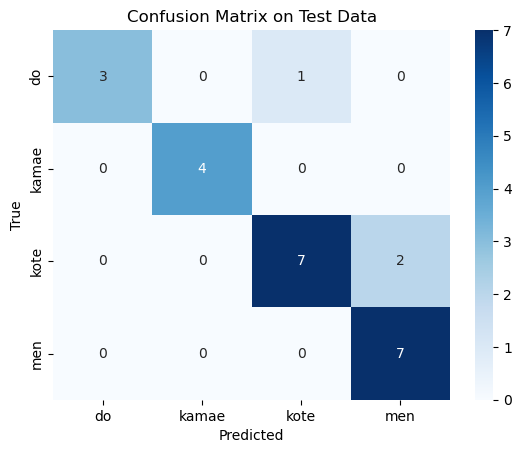

In [69]:
# Load test dataset
test_df = pd.read_csv('local_test_2.csv') #This is the renamed kendo_data.csv

# Extract features and labels
test_features = extract_features2(test_df, move_label_column='label')

# Prepare feature matrix (X_test) and true labels (y_test_true)
X_test = test_features.drop(columns=['label'])
y_test_true = le.transform(test_features['label'])  # Align labels to windows

X_test_scaled = scaler.transform(X_test)
y_test_pred = classifier.predict(X_test_scaled)


# Accuracy and F1-Score
accuracy = accuracy_score(y_test_true, y_test_pred)
f1 = f1_score(y_test_true, y_test_pred, average='weighted')

# Print evaluation metrics
print(f'Accuracy: {accuracy:.3f}')
print(f'Weighted F1-Score: {f1:.3f}')
print('Test Classification Report:')
print(classification_report(y_test_true, y_test_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_true, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Data')
plt.show()